<a href="https://colab.research.google.com/github/bcguilherme/bcguilherme/blob/main/Notebook_data_wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform

from IPython.core.display import HTML
from ipywidgets import interact, widgets

In [ ]:
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8)
    }
)

In [ ]:
#função pra deixar as tabelas na mesma linha (lado a lado)
def display_side_by_side(dataframes:list,titles:list):
    html_str=''
    for df,title in zip(dataframes, titles):
        html_str+=f'<span>{title}:</span>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+="&nbsp"*10
    display(HTML(html_str))

# **Estruturação dos dados**

## Merge/Concat/Join

Frequentemente precisamos juntar bases diferentes em um só, para tanto para facilitar análise exploratória quanto para preparar o dataset para modelagem.

As funções `merge`, `concat` e `join` do Pandas nos ajudam nesta parte de estruturação dos dados, e há um tutorial excelente do próprio Pandas [neste link](https://pandas.pydata.org/docs/user_guide/merging.html#merge-join-concatenate-and-compare).

### Merge

Este método do pandas é o mais similar aos JOINs do SQL.  
Tabela de exemplo comparativo:


| Merge method   | SQL Join Name    | Description                                         |
|:---------------|:-----------------|:----------------------------------------------------|
| left           | LEFT OUTER JOIN  | Use keys from left frame only                       |
| right          | RIGHT OUTER JOIN | Use keys from right frame only                      |
| outer          | FULL OUTER JOIN  | Use union of keys from both frames                  |
| inner          | INNER JOIN       | Use intersection of keys from both frames           |
| cross          | CROSS JOIN       | Create the cartesian product of rows of both frames |

In [ ]:
df1 = pd.DataFrame(
    {
        "key": ["K0", "K1", "K2", "K3"],
        "A": ["A0", "A1", "A2", "A3"],
        "B": ["B0", "B1", "B2", "B3"],
    }, index=range(4)
)

df2 = pd.DataFrame(
    {
        "key": ["K1", "K2", "K3", "K4"],
        "C": ["C1", "C2", "C3", "C4"],
        "D": ["D1", "D2", "D3", "D4"],
    }, index=range(1,5)
)

df3 = pd.DataFrame(
    {
        "key": ["K1", "K2", "K3", "K4"],
        "E": ["E1", "E2", "E3", "E4"],
        "F": ["F1", "F2", "F3", "F4"],
    }, index=range(1,5)
)

In [ ]:
display_side_by_side([df1,df2, df3], ['df1','df2', 'df3'])

,key,A,B
0,K0,A0,B0
1,K1,A1,B1
2,K2,A2,B2
3,K3,A3,B3
,key,C,D
1,K1,C1,D1
2,K2,C2,D2
3,K3,C3,D3
4,K4,C4,D4
,key,E,F


In [ ]:
# Mostrar merge dos dois jeitos esse exemplo assim:
#exemplo 1:
df1.merge(df2)

# Por padrão, ele traz um inner join das tabelas, trazendo somente os resultados que convergem


,key,A,B,C,D
0,K1,A1,B1,C1,D1
1,K2,A2,B2,C2,D2
2,K3,A3,B3,C3,D3


In [ ]:
# Exemplo 2:
df1.merge(df3, on='key', how='inner')

# Também é possível setar como queremos a convergencia

,key,A,B,E,F
0,K1,A1,B1,E1,F1
1,K2,A2,B2,E2,F2
2,K3,A3,B3,E3,F3


In [ ]:
# Mostrar todos
df_inner = df1.merge(df2, on='key', how='inner') #mantém todas as categorias em comum nos dois df
df_left = df1.merge(df2, on='key', how='left') #mantém todas as categorias existentes na coluna da esquerda
df_right = df1.merge(df2, on='key', how='right') #mantém todas as categorias existentes na coluna da direita


#Função de mostrar tabela -> display_side_by_side([lista = formato string])

display_side_by_side(
    dataframes=[df1, df2, df_inner, df_left, df_right],
    titles=['df1', 'df2', 'inner_merge', 'left_merge', 'right_merge']
)

In [ ]:
#função merge da aula
@interact(method=['inner','left', 'right','outer'])
def merge(method):
  df_merge=df1.merge(df2, how=method)
  display_side_by_side(
      [df1,df2,df_merge],
      ['df1','df2',f'{method}_join']
  )

interactive(children=(Dropdown(description='method', options=('inner', 'left', 'right', 'outer'), value='inner…

In [ ]:
def merge(merge_method):
  display_side_by_side([df1, df2, df1.merge(df2, how=merge_method)], ['df1','df2', f'{merge_method} merge'])

interact(merge, df1=df1, df2=df2, merge_method=widgets.Dropdown(options=['inner','left','right','outer'], style={'description_width': 'initial'}));

interactive(children=(Dropdown(description='merge_method', options=('inner', 'left', 'right', 'outer'), style=…

### Concat

A concatenação acontece quando temos que juntar as tabelas uma abaixo da outra (equivalente ao `UNION` do  SQL), ou uma ao lado da outra.

Por exemplo de concatenação vertical (default) `pd.concat([df1,df2,df3])`:  
![](https://pandas.pydata.org/docs/_images/merging_concat_basic.png)  
<caption><b>Fonte:</b> <a href="https://pandas.pydata.org/docs/user_guide/merging.html">https://pandas.pydata.org/docs/user_guide/merging.html</a></caption>

Exemplo de concatenação horizontal (`pd.concat([df1,df4], axis=1)`):
![](https://pandas.pydata.org/docs/_images/merging_concat_axis1.png)  
<caption><b>Fonte:</b> <a href="https://pandas.pydata.org/docs/user_guide/merging.html">https://pandas.pydata.org/docs/user_guide/merging.html</a></caption>





In [ ]:
#@title
%%html
<style>
div.warn {
    color: #9E8C50;
    background-color: #F8F4C3;
    border-left: 5px solid #9E8C50;
    padding: 0.5em;
    }
 </style>
<div class=warn>
<b>Nota: </b> Observe que, por padrão, Pandas considera os nomes das colunas e índeces ao unir as tabelas.
</div>

In [ ]:
# Separando exemplo de data_frame
df_A = df1.iloc[:2]
df_B = df1.iloc[2:]
display_side_by_side([df_A,df_B], ['df_A','df_B'])

,key,A,B
0,K0,A0,B0
1,K1,A1,B1
,key,A,B
2,K2,A2,B2
3,K3,A3,B3


In [ ]:
# Concatenando verticalmente
pd.concat([df_A,df_B])

,key,A,B
0,K0,A0,B0
1,K1,A1,B1
2,K2,A2,B2
3,K3,A3,B3


In [ ]:
# Concatenando horizontalmente
pd.concat([df_A,df_B], axis=1)

,key,A,B,key,A,B
0,K0,A0,B0,NaN,NaN,NaN
1,K1,A1,B1,NaN,NaN,NaN
2,NaN,NaN,NaN,K2,A2,B2
3,NaN,NaN,NaN,K3,A3,B3


In [ ]:
# Concatenando horizontalmente, forçando mesmo index
pd.concat([df_A,df_B.reset_index()], axis=1)

,key,A,B,index,key,A,B
0,K0,A0,B0,2,K2,A2,B2
1,K1,A1,B1,3,K3,A3,B3


### Join

A função join do Pandas considere como chave o index:

![](https://pandas.pydata.org/docs/_images/merging_join.png)

In [ ]:
df_left = pd.DataFrame({
    'A':['A0', 'A1', 'A2'],
    'B':['B0','B1','B2']
}, index=['K0','K1','K2'])

df_right = pd.DataFrame({
    'C':['C0','C1', 'C2'],
    'D':['D0','D1','D2']
}, index=['K0','K2','K3'])

df_join = df_left.join(df_right, how='inner')

display_side_by_side([df_left, df_right, df_join],['df_left', 'df_right', 'df_join'] )

## Group by

Um dos métodos mais utilizados do Pandas (e em outras linguagens) é o `groupby`.

A lógica do `groupby` é bem simples e conhecida como **split-apply-combine:**

1. A primeira etapa é separar a tabela (split) em tabelas menores, cada uma com categorias únicas (representando um grupo) da(s) coluna(s) que desejamos agrupar.
2. Aplicar uma função separadamente em cada uma destas tabelas. Pode ser uma função de **agregação** gerando uma métrica de resumo, uma função de **transformação**, modificando os valores, ou uma função de **filtro**, onde filtraremos grupos que se encaixam dentro de uma regra.
3. Por fim, combina-se novamente estas tabelas para formar uma única tabela de saída.

Segue um esquema de exemplo com um função de agregação (soma):

![](https://miro.medium.com/max/2400/1*w2oGdXv5btEMxAkAsz8fbg.png)  
Fonte: [https://medium.com/analytics-vidhya/split-apply-combine-strategy-for-data-mining-4fd6e2a0cc99](https://medium.com/analytics-vidhya/split-apply-combine-strategy-for-data-mining-4fd6e2a0cc99)

Maiores detalhes no [guia de uso da documentação](https://pandas.pydata.org/docs/user_guide/groupby.html#group-by-split-apply-combine).

In [ ]:
# Vamos utilizar como exemplo o dataset de gorjetas em um restaurante
df = sns.load_dataset('tips')
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


###Agregações


In [ ]:
# Podemos agrupar por uma coluna e aplicar uma função em todas colunas (passíveis de aplicação da função)
df.groupby(['sex']).mean()

,total_bill,tip,size
sex,,,
Male,20.744076,3.089618,2.630573
Female,18.056897,2.833448,2.459770


In [ ]:
# Podemos agrupar por uma coluna e aplicar uma função em uma coluna-alvo retornando um pandas.Series
df.groupby('sex')['total_bill'].mean()

sex
Male      20.744076
Female    18.056897
Name: total_bill, dtype: float64

In [ ]:
# Podemos agrupar por uma coluna e aplicar uma função em um coluna-alvo retornando um pandas.DataFrame (duplo "[[")
df.groupby(['smoker'])[['total_bill']].sum()

,total_bill
smoker,
Yes,1930.34
No,2897.43


In [ ]:
# Podemos agrupar por múltiplas colunas
df.groupby(['time','day'])[['total_bill', 'tip']].agg(['mean', 'max','min', 'sum', 'count'])

total_bill                                    tip               \
                  mean    max    min      sum count      mean    max   min   
time   day                                                                   
Lunch  Thur  17.664754  43.11   7.51  1077.55    61  2.767705   6.70  1.25   
       Fri   12.845714  16.27   8.58    89.92     7  2.382857   3.48  1.58   
       Sat         NaN    NaN    NaN     0.00     0       NaN    NaN   NaN   
       Sun         NaN    NaN    NaN     0.00     0       NaN    NaN   NaN   
Dinner Thur  18.780000  18.78  18.78    18.78     1  3.000000   3.00  3.00   
       Fri   19.663333  40.17   5.75   235.96    12  2.940000   4.73  1.00   
       Sat   20.441379  50.81   3.07  1778.40    87  2.993103  10.00  1.00   
       Sun   21.410000  48.17   7.25  1627.16    76  3.255132   6.50  1.01   

                           
                sum count  
time   day                 
Lunch  Thur  168.83    61  
       Fri    16.68     7  
       Sat     0.00     0  
       Sun     0.00     0  
Dinner Thur    3.00     1  
       Fri    35.28    12  
       Sat   260.40    87  
       Sun   247.39    76

In [ ]:
# Podemos aplicar múltiplas funções de agregação suportadas pelo pandas
df.groupby(['time'])[['total_bill']].agg(['min','median','max'])

total_bill               
              min  median    max
time                            
Lunch        7.51  15.965  43.11
Dinner       3.07  18.390  50.81

In [ ]:
# Podemos aplicar funções customizadas simples
df.groupby(['time'])[['total_bill']].apply(lambda x: np.sum(x)+1)

,total_bill
time,
Lunch,1168.47
Dinner,3661.30


In [ ]:
## Mais exemplos

# Podemos agrupar por uma coluna e aplicar uma função em todas colunas (passíveis de aplicação da função)
df.groupby(['sex']).sum()

# Podemos agrupar por uma coluna e aplicar uma função em um coluna-alvo retornando um pandas.Series
df.groupby(['sex'])['total_bill'].sum()

# Podemos agrupar por uma coluna e aplicar uma função em um coluna-alvo retornando um pandas.DataFrame (duplo "[[")
df.groupby(['smoker'])[['total_bill']].sum()

# Podemos agrupar por múltiplas colunas
df.groupby(['sex','smoker'])[['total_bill']].mean()

# Podemos aplicar múltiplas funções de agregação suportadas pelo pandas
df.groupby(['time'])[['total_bill']].agg(['min','median','max'])

# Podemos aplicar funções customizadas simples
df.groupby(['time'])[['total_bill']].apply(lambda x: np.sum(x)+1)

# Podemos aplicar funções customizadas mais complexas
def mean_diff(subdf):
  """Calcula a média do quanto cada gorjeta representou da conta total"""
  return np.mean( subdf['tip'] / subdf['total_bill'] )

df.groupby('sex').apply(lambda x: str(round(mean_diff(x)*100, 2))+'%')



sex
Male      15.77%
Female    16.65%
dtype: object

In [ ]:
## -- Transformação -- ##

# Padronização por grupo
df.groupby('sex')[['total_bill','tip']].transform(scale)

# Rolling mean
df.groupby('sex')[['total_bill','tip']].rolling(3).mean()

total_bill       tip
sex                             
Male   1           NaN       NaN
       2           NaN       NaN
       3     18.343333  2.823333
       5     23.326667  3.840000
       6     19.246667  3.340000
...                ...       ...
Female 226   14.113333  2.500000
       229   16.160000  2.460000
       238   22.680000  3.183333
       240   28.376667  3.183333
       243   27.263333  3.223333

[244 rows x 2 columns]

In [ ]:
groups = df.groupby(['sex','smoker'])

In [ ]:
groups.get_group(('Female','Yes'))

,total_bill,tip,sex,smoker,day,time,size
67,3.07,1.00,Female,Yes,Sat,Dinner,1
72,26.86,3.14,Female,Yes,Sat,Dinner,2
73,25.28,5.00,Female,Yes,Sat,Dinner,2
92,5.75,1.00,Female,Yes,Fri,Dinner,2
93,16.32,4.30,Female,Yes,Fri,Dinner,2
100,11.35,2.50,Female,Yes,Fri,Dinner,2
101,15.38,3.00,Female,Yes,Fri,Dinner,2
102,44.30,2.50,Female,Yes,Sat,Dinner,3
103,22.42,3.48,Female,Yes,Sat,Dinner,2
109,14.31,4.00,Female,Yes,Sat,Dinner,2


###Demonstração Gráfica

sex     smoker
Male    Yes       183.07
        No        302.00
Female  Yes        96.74
        No        149.77
Name: tip, dtype: float64 



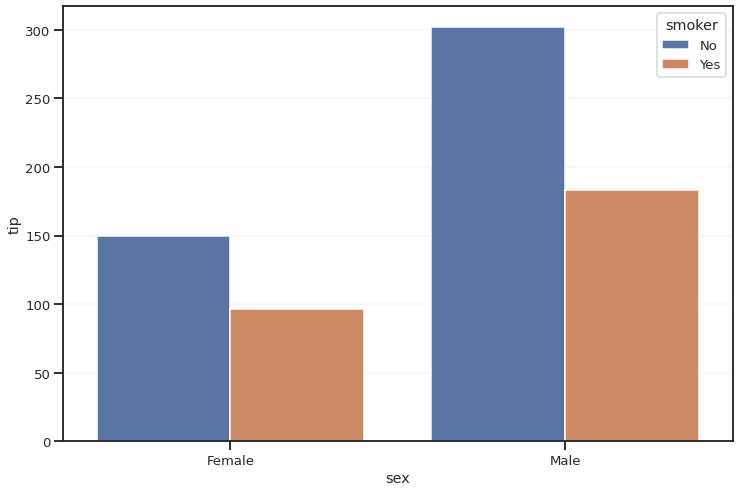

In [ ]:
# Exemplo das mesmas informações com groupby e plot

# Groupby
print(df.groupby(['sex','smoker']).tip.sum(), '\n')

# Seaborn barplot
sns.barplot(data=df, x='sex', y='tip', hue='smoker', order=['Female','Male'], hue_order=['No','Yes'], estimator=np.sum, ci=False)
plt.grid(axis='y', alpha=.2)
plt.show()

# Plotly barplot
px.bar(data_frame=df, x='sex', y='tip', color='smoker', barmode="group")

## Pivot table

In [ ]:
# primeiras linhas
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [ ]:
# exemplo de pivot: sex - time - tip
df.pivot_table(index='sex', columns='day', values='tip')

# Padrão dos valores é a média

day,Thur,Fri,Sat,Sun
sex,,,,
Male,2.980333,2.693000,3.083898,3.220345
Female,2.575625,2.781111,2.801786,3.367222


In [ ]:
# exemplo de pivot: sex - time - total_bill/tip
df.pivot_table(index='sex', columns='time', values=['total_bill','tip'], aggfunc=['sum', 'mean'])

sum                                  mean                       \
          tip         total_bill                tip           total_bill   
time    Lunch  Dinner      Lunch   Dinner     Lunch    Dinner      Lunch   
sex                                                                        
Male    95.11  389.96     595.60  2661.22  2.882121  3.144839  18.048485   
Female  90.40  156.11     571.87   999.08  2.582857  3.002115  16.339143   

                   
                   
time       Dinner  
sex                
Male    21.461452  
Female  19.213077

In [ ]:
# exemplo de pivot: sex - time/day - total_bill/tip
df.pivot_table(index='sex', columns=['time','day'], values=['total_bill','tip'], aggfunc=np.median)

tip                                 total_bill                       \
time   Lunch       Dinner                         Lunch        Dinner          
day     Thur   Fri   Thur  Fri    Sat    Sun       Thur    Fri   Thur    Fri   
sex                                                                            
Male    2.53  1.92    NaN  3.0  3.000  3.085     16.975  12.16    NaN  22.49   
Female  2.00  2.75    3.0  3.0  2.625  3.500     13.420  14.70  18.78  15.38   

                       
time                   
day       Sat     Sun  
sex                    
Male    18.24  20.725  
Female  18.36  17.410

In [ ]:
# Exemplo com groupby para comparação
df.groupby(['sex','time','day'])[['total_bill','tip']].median()

total_bill    tip
sex    time   day                    
Male   Lunch  Thur      16.975  2.530
              Fri       12.160  1.920
              Sat          NaN    NaN
              Sun          NaN    NaN
       Dinner Thur         NaN    NaN
              Fri       22.490  3.000
              Sat       18.240  3.000
              Sun       20.725  3.085
Female Lunch  Thur      13.420  2.000
              Fri       14.700  2.750
              Sat          NaN    NaN
              Sun          NaN    NaN
       Dinner Thur      18.780  3.000
              Fri       15.380  3.000
              Sat       18.360  2.625
              Sun       17.410  3.500

In [ ]:
# Exemplo de pivot com múltiplas funções de agregação
df.pivot_table(index='sex', columns='time', values='tip', aggfunc=['mean', np.median, np.std, lambda x: x.sum()])

mean           median              std           <lambda>        
time       Lunch    Dinner  Lunch Dinner     Lunch    Dinner    Lunch  Dinner
sex                                                                          
Male    2.882121  3.144839   2.31    3.0  1.329017  1.529116    95.11  389.96
Female  2.582857  3.002115   2.01    3.0  1.075108  1.193483    90.40  156.11

In [ ]:
# Exemplo de pivot especificando funções em dicionário

agg_dict = {'tip': 'mean', 'total_bill':[np.median, 'min']}

df.pivot_table(index='sex', columns='time', aggfunc=agg_dict)

tip           total_bill                    
            mean               median          min       
time       Lunch    Dinner      Lunch Dinner Lunch Dinner
sex                                                      
Male    2.882121  3.144839      16.58  19.63  7.51   7.25
Female  2.582857  3.002115      13.42  17.19  8.35   3.07

Tabelas no formato long e wide:

In [ ]:
df.groupby(['day','time'])['tip'].mean()

day   time  
Thur  Lunch     2.767705
      Dinner    3.000000
Fri   Lunch     2.382857
      Dinner    2.940000
Sat   Lunch          NaN
      Dinner    2.993103
Sun   Lunch          NaN
      Dinner    3.255132
Name: tip, dtype: float64

In [ ]:
df.pivot_table(index='time', columns='day', values='tip')

day,Thur,Fri,Sat,Sun
time,,,,
Lunch,2.767705,2.382857,NaN,NaN
Dinner,3.000000,2.940000,2.993103,3.255132


In [ ]:
# Selecionando as colunas day,time e tip, a tabela pode ser considerada long, pois elementos se repetem:
df_pivot = df.pivot_table(index='day', columns='time', values='tip').reset_index()
df_pivot

time,day,Lunch,Dinner
0,Thur,2.767705,3.000000
1,Fri,2.382857,2.940000
2,Sat,NaN,2.993103
3,Sun,NaN,3.255132


In [ ]:
# Usando pivot_table, a tabela ficaria no formato wide, pois os elementos não se repetem
df_pivot.melt(id_vars='day')\


,day,time,value
0,Thur,Lunch,2.767705
1,Fri,Lunch,2.382857
2,Sat,Lunch,NaN
3,Sun,Lunch,NaN
4,Thur,Dinner,3.000000
5,Fri,Dinner,2.940000
6,Sat,Dinner,2.993103
7,Sun,Dinner,3.255132


In [ ]:
# Para transformar em long novamente, utilizamos a função `melt` e podemos plotar utilizando seaborn/plotly
df_pivot.melt(id_vars='day')\
.plot.bar(backend='plotly', x='day', y='value', color='time', barmode='group')

# Categorical encoding

**Disclaimer sobre variáveis numéricas:**

Para as variáveis numéricas, alguns algoritmos requerem que os dados estejam **padronizados**. Vimos em data cleaning, ao lidar com outliers, a função `scale` do `sklearn` que padroniza por Z-score. Vale olhar também o `minmax_scale`, outro metódo de pradonização comum que transforma os dados em valores de 0 a 1 (zero sendo o valor mínimo e 1 o máximo).

Também vimos as funções de **transformação** como Box-Cox, que aproxima a distribuição dos dados à uma distribuição normal.

Todos estes métodos já foram abordados e podem ser utilizados para tratar variáveis numéricas para modelos que necessitem deste tratamento.

&nbsp;

---

&nbsp;

**Encoding de variáveis categóricas**

As variáveis categóricas precisam, necessariamente, ser tratadas para que sejam representadas por números, uma vez que os modelos não compreendem texto.

Obs: Alguns modelos podem até permitir input de texto, mas dentro deles eles mesmos fazem essa tratativa de encoding.

Existem duas abordagens principais para encoding de variáveis categóricas:
1. OneHotEncoding: criação de novas colunas para cada categoria informando se esta categoria está ou não presente nas respectivas observações
2. LabelEncoder/OrdinalEncoder: substitui o texto das categorias por números, matendo um "dicionário" para saber ter o mapeamento do que cada número representa.

## OneHotEncoder

Uma opção seria utilizar diretamente o pandas para este propósito:

In [ ]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [ ]:
pd.get_dummies(df)

,total_bill,tip,size,sex_Male,sex_Female,smoker_Yes,smoker_No,day_Thur,day_Fri,day_Sat,day_Sun,time_Lunch,time_Dinner
0,16.99,1.01,2,0,1,0,1,0,0,0,1,0,1
1,10.34,1.66,3,1,0,0,1,0,0,0,1,0,1
2,21.01,3.50,3,1,0,0,1,0,0,0,1,0,1
3,23.68,3.31,2,1,0,0,1,0,0,0,1,0,1
4,24.59,3.61,4,0,1,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,3,1,0,0,1,0,0,1,0,0,1
240,27.18,2.00,2,0,1,1,0,0,0,1,0,0,1
241,22.67,2.00,2,1,0,1,0,0,0,1,0,0,1
242,17.82,1.75,2,1,0,0,1,0,0,1,0,0,1


Ou também podemos utilizar

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(drop='if_binary')
encoder

OneHotEncoder(drop='if_binary')

In [ ]:
df.select_dtypes(exclude='category')

,total_bill,tip,size
0,16.99,1.01,2
1,10.34,1.66,3
2,21.01,3.50,3
3,23.68,3.31,2
4,24.59,3.61,4
...,...,...,...
239,29.03,5.92,3
240,27.18,2.00,2
241,22.67,2.00,2
242,17.82,1.75,2


In [ ]:
categorical_columns = df.select_dtypes(exclude='number').columns

In [ ]:
encoder.fit(df[categorical_columns])

OneHotEncoder(drop='if_binary')

In [ ]:
encoder.categories_
encoder.drop_idx_
encoder.feature_names_in_
encoder.get_feature_names_out()

array(['sex_Male', 'smoker_Yes', 'day_Fri', 'day_Sat', 'day_Sun',
       'day_Thur', 'time_Lunch'], dtype=object)

In [ ]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Fri', 'Sat', 'Sun', 'Thur'], dtype=object),
 array(['Dinner', 'Lunch'], dtype=object)]

In [ ]:
encoder.drop_idx_

array([0, 0, None, 0], dtype=object)

In [ ]:
encoder.feature_names_in_

array(['sex', 'smoker', 'day', 'time'], dtype=object)

In [ ]:
encoder.get_feature_names_out()

array(['sex_Male', 'smoker_Yes', 'day_Fri', 'day_Sat', 'day_Sun',
       'day_Thur', 'time_Lunch'], dtype=object)

In [ ]:
pd.DataFrame(
    data=encoder.transform(df[categorical_columns]).toarray(),
    columns=encoder.get_feature_names_out()
)

,sex_Male,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Lunch
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
239,1.0,0.0,0.0,1.0,0.0,0.0,0.0
240,0.0,1.0,0.0,1.0,0.0,0.0,0.0
241,1.0,1.0,0.0,1.0,0.0,0.0,0.0
242,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
encoder.transform(df[categorical_columns].replace({'Male':'male'}))

ValueError: ignored

## LabelEncoder / OrdinalEncoder

Usando pandas

In [ ]:
# Convertendo para categoria
df_cat = df.copy()

df_cat[categorical_columns] = df_cat[categorical_columns].astype('category')
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [ ]:
{col: dict( enumerate(df_cat[col].cat.categories) ) for col in categorical_columns}

{'sex': {0: 'Male', 1: 'Female'},
 'smoker': {0: 'Yes', 1: 'No'},
 'day': {0: 'Thur', 1: 'Fri', 2: 'Sat', 3: 'Sun'},
 'time': {0: 'Lunch', 1: 'Dinner'}}

In [ ]:
# Pegando das categorias

In [ ]:
# Modificando colunas
df_cat[categorical_columns] = df_cat[categorical_columns].apply(lambda x: x.cat.codes)

In [ ]:
df_cat.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,1,1,3,1,2
1,10.34,1.66,0,1,3,1,3
2,21.01,3.50,0,1,3,1,3
3,23.68,3.31,0,1,3,1,2
4,24.59,3.61,1,1,3,1,4


In [ ]:
# Usando factorize
df['sex'].factorize()

(array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
        1, 0]),
 CategoricalIndex(['Female', 'Male'], categories=['Male', 'Female'], ordered=False, dtype='category'))

Usando sklearn

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
OrdinalEncoder?

In [ ]:
# Instanciando OrginalEncoder
encoder = OrdinalEncoder().fit(df[categorical_columns])

In [ ]:
# Mostrando atributos
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Fri', 'Sat', 'Sun', 'Thur'], dtype=object),
 array(['Dinner', 'Lunch'], dtype=object)]

In [ ]:
# Transformando dados esperados
df_cat[categorical_columns] = encoder.transform(df[categorical_columns])

In [ ]:
df_cat.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0.0,0.0,2.0,0.0,2
1,10.34,1.66,1.0,0.0,2.0,0.0,3
2,21.01,3.50,1.0,0.0,2.0,0.0,3
3,23.68,3.31,1.0,0.0,2.0,0.0,2
4,24.59,3.61,0.0,0.0,2.0,0.0,4


# Filtros

# New Section

In [ ]:
# Filtro convencional
df.head()

df[df.tip > 4].head()

,total_bill,tip,sex,smoker,day,time,size
5,25.29,4.71,Male,No,Sun,Dinner,4
11,35.26,5.00,Female,No,Sun,Dinner,4
20,17.92,4.08,Male,No,Sat,Dinner,2
23,39.42,7.58,Male,No,Sat,Dinner,4
28,21.70,4.30,Male,No,Sat,Dinner,2


In [ ]:
# Filtro com query

df.query('tip > 4').head()

,total_bill,tip,sex,smoker,day,time,size
5,25.29,4.71,Male,No,Sun,Dinner,4
11,35.26,5.00,Female,No,Sun,Dinner,4
20,17.92,4.08,Male,No,Sat,Dinner,2
23,39.42,7.58,Male,No,Sat,Dinner,4
28,21.70,4.30,Male,No,Sat,Dinner,2


In [ ]:
# Filtro com query e variável
minimo_aceitavel = 3
df.query('tip>@minimo_aceitavel')

,total_bill,tip,sex,smoker,day,time,size
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
7,26.88,3.12,Male,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
219,30.14,3.09,Female,Yes,Sat,Dinner,4
221,13.42,3.48,Female,Yes,Fri,Lunch,2
232,11.61,3.39,Male,No,Sat,Dinner,2
238,35.83,4.67,Female,No,Sat,Dinner,3


In [ ]:
# Múltiplos filtros convencionais
df[ (df.tip>2) & (df.total_bill<20)].head()

,total_bill,tip,sex,smoker,day,time,size
9,14.78,3.23,Male,No,Sun,Dinner,2
13,18.43,3.00,Male,No,Sun,Dinner,4
14,14.83,3.02,Female,No,Sun,Dinner,2
17,16.29,3.71,Male,No,Sun,Dinner,3
18,16.97,3.50,Female,No,Sun,Dinner,3


In [ ]:
df.day.unique()

['Sun', 'Sat', 'Thur', 'Fri']
Categories (4, object): ['Thur', 'Fri', 'Sat', 'Sun']

In [ ]:
df[df.day.isin(['Sat','Sun'])].day.unique()

['Sun', 'Sat']
Categories (4, object): ['Thur', 'Fri', 'Sat', 'Sun']

In [ ]:
# Múltiplos filtros com query
df.query('tip>2 & total_bill<20').head()

,total_bill,tip,sex,smoker,day,time,size
9,14.78,3.23,Male,No,Sun,Dinner,2
13,18.43,3.00,Male,No,Sun,Dinner,4
14,14.83,3.02,Female,No,Sun,Dinner,2
17,16.29,3.71,Male,No,Sun,Dinner,3
18,16.97,3.50,Female,No,Sun,Dinner,3


In [ ]:
# Filtro com index
df_index = df.set_index('sex')
df_index

,total_bill,tip,smoker,day,time,size
sex,,,,,,
Female,16.99,1.01,No,Sun,Dinner,2
Male,10.34,1.66,No,Sun,Dinner,3
Male,21.01,3.50,No,Sun,Dinner,3
Male,23.68,3.31,No,Sun,Dinner,2
Female,24.59,3.61,No,Sun,Dinner,4
...,...,...,...,...,...,...
Male,29.03,5.92,No,Sat,Dinner,3
Female,27.18,2.00,Yes,Sat,Dinner,2
Male,22.67,2.00,Yes,Sat,Dinner,2


In [ ]:
df_index.loc['Female', ['total_bill','tip']]

,total_bill,tip
sex,,
Female,16.99,1.01
Female,24.59,3.61
Female,35.26,5.00
Female,14.83,3.02
Female,10.33,1.67
...,...,...
Female,10.09,2.00
Female,22.12,2.88
Female,35.83,4.67


Filtrando data

In [ ]:
# Loading aircrash dataset
fatalities_dataset_path = 'https://query.data.world/s/2gfb7bmzhna6kcbpc7admwa6cexprz'
df_datetime = pd.read_csv(fatalities_dataset_path, usecols=['Date','Fatalities'], parse_dates=['Date'], index_col='Date').sort_index()
df_datetime.head()

,Fatalities
Date,
1908-09-17,1.0
1912-07-12,5.0
1913-08-06,1.0
1913-09-09,14.0
1913-10-17,30.0


In [ ]:
# Filtrando com .loc
df_datetime.loc['2000-05-10':'2010-05-10']

,Fatalities
Date,
2000-05-10,6.0
2000-05-17,3.0
2000-05-21,19.0
2000-05-25,1.0
2000-05-25,1.0
...,...
2009-05-20,98.0
2009-05-26,4.0
2009-06-01,228.0


In [ ]:
# Resetando index
df = df_datetime.reset_index()
df.head()

,Date,Fatalities
0,1908-09-17,1.0
1,1912-07-12,5.0
2,1913-08-06,1.0
3,1913-09-09,14.0
4,1913-10-17,30.0


In [ ]:
# Filtrando com filtro convencional de coluna - between
df[df.Date.between('2000-05-10', '2010-05-10')]

,Date,Fatalities
4710,2000-05-10,6.0
4711,2000-05-17,3.0
4712,2000-05-21,19.0
4713,2000-05-25,1.0
4714,2000-05-25,1.0
...,...,...
5263,2009-05-20,98.0
5264,2009-05-26,4.0
5265,2009-06-01,228.0
5266,2009-06-07,1.0


In [ ]:
# Filtrando com filtro convencional de coluna - gt/lt
df[(df.Date>='2000-05-10') & (df.Date.le('2010-05-10'))]

,Date,Fatalities
4710,2000-05-10,6.0
4711,2000-05-17,3.0
4712,2000-05-21,19.0
4713,2000-05-25,1.0
4714,2000-05-25,1.0
...,...,...
5263,2009-05-20,98.0
5264,2009-05-26,4.0
5265,2009-06-01,228.0
5266,2009-06-07,1.0


# Enriquecimento (Feature Engineering)

Feature engineering, ou enriquecimento, consiste em uma das etapas mais importantes para construir bons modelos de machine learning.

O objetivo da feature engineering é tornar os dados melhor aproveitáveis para resolver o problema proposto. Através da feature engineering, podemos:

- Melhor a performance preditiva do modelo
- Reduzir custos computacionais ou necessidades de dados
- Aumentar a interpretabilidade dos resultados

Novas features podem ser geradas a partir das próprias features do datataset através de operações aritméticas simples. Conside por exemplo o dataset de gorjetas previamente estudado:

In [ ]:
df = sns.load_dataset('tips')
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Neste caso, poderíamos adicionar uma coluna que representa o quanto a gorjeta representa da conta total, ou o valor da conta divido pelo tamanho da mesa (size):

In [ ]:
df['tip_normalized'] = df['tip'] / df['total_bill']
df.head()

,total_bill,tip,sex,smoker,day,time,size,tip_normalized
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


Lembre-se, contudo, que para um modelo supervisionado de machine learning, todas as features trabalhadas no treino devem ser possíveis de serem utilizada em novos dados que virão também, como input do modelo.

Outra maneira de adicionar colunas consiste em capturar categorias mais específicas em uma variável categórica com texto.

Por exemplo, considere a base de dados do Titanic:

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Nesta base, o nome do completo do passageiro não seria útil, visto que são nomes únicos. Contudo, há um tratamento pessoal em cada nome (como Mr., Mrs.) e isso poderia contribuir para melhor performance do modelo.

In [ ]:
df.Name.str.extract('.+?, (.+?)\.', expand=False)

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
       ... 
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Name: Name, Length: 891, dtype: object

In [ ]:
df['personal_title'] = df.Name.str.extract('.+?, (.+?)\.', expand=False)
df.head()

# '.+?, (.+?)\. > padrão no texto, depois da virgula e antes do ponto

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,personal_title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


## Selecionando features

A parte de seleção de features também é muito importante e o domínio de negócio/área conta muito aqui.

### Análise gráfica

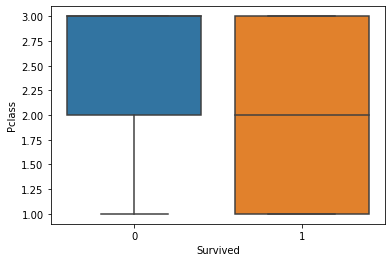

In [ ]:
# Observando diferenças nas distribuições
sns.boxplot(data=df, x='Survived', y='Pclass');

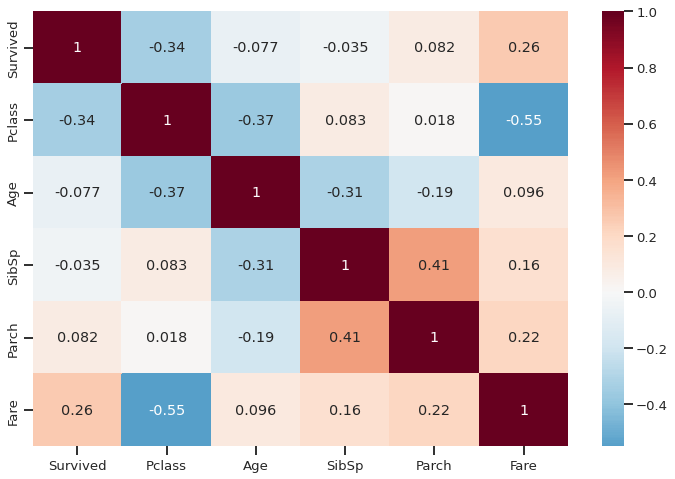

In [ ]:
# Observando correlação (linear)
sns.heatmap(df.corr(), cmap='RdBu_r', center=0, annot=True);

### Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

In [ ]:
# Drop columns and NAs
df_model = df.drop(columns=['Name','Ticket','Cabin']).dropna()
df_model.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,personal_title
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Mr
2,1,1,female,38.0,1,0,71.2833,C,Mrs
3,1,3,female,26.0,0,0,7.9250,S,Miss
4,1,1,female,35.0,1,0,53.1000,S,Mrs
5,0,3,male,35.0,0,0,8.0500,S,Mr


In [ ]:
target = df_model['Survived']
df_features = df_model.drop(columns='Survived')

In [ ]:
cat_features = df_features.select_dtypes(exclude='number').columns

encoder = OrdinalEncoder()
df_features[cat_features] = encoder.fit_transform(df_features[cat_features]).astype(int)

df_features.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,personal_title
PassengerId,,,,,,,,
1,3,1,22.0,1,0,7.2500,2,11
2,1,0,38.0,1,0,71.2833,0,12
3,3,0,26.0,0,0,7.9250,2,8
4,1,0,35.0,1,0,53.1000,2,12
5,3,1,35.0,0,0,8.0500,2,11


In [ ]:
discrete_features = df_features.dtypes==int
discrete_features

Pclass             True
Sex                True
Age               False
SibSp              True
Parch              True
Fare              False
Embarked           True
personal_title     True
dtype: bool

In [ ]:
scores = mutual_info_classif(X=df_features, y=target, discrete_features=discrete_features)
scores

array([0.06516276, 0.14840857, 0.00676764, 0.01723787, 0.02126715,
       0.13961511, 0.01930984, 0.17785974])

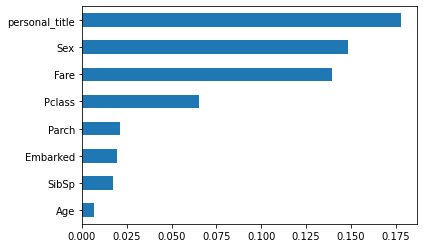

In [ ]:
pd.Series(data=scores, index=df_features.columns).sort_values().plot.barh()

**Observação:** MI, assim como correlação, é uma métrica **univariada**, portanto, não necessariamente uma variável com baixo score de MI vai ter pouca importância para o modelo, pois pode ser que, quando associada à outra variável, ambas variáveis contribuam para o modelo.

# Pipelines

In [ ]:
from sklearn import set_config
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder

set_config(display="diagram")

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv', index_col='PassengerId')
df['personal_titles'] = df.Name.str.extract('.*, (.+?)\.', expand=False)
df = df.drop(columns=['Name','Ticket','Cabin']).dropna()

df_features = df.drop(columns='Survived')
target = df['Survived']

df_features.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,personal_titles
PassengerId,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,Mr
2,1,female,38.0,1,0,71.2833,C,Mrs
3,3,female,26.0,0,0,7.9250,S,Miss
4,1,female,35.0,1,0,53.1000,S,Mrs
5,3,male,35.0,0,0,8.0500,S,Mr


In [ ]:
# Selecionando features numéricas e categóricas
numerical_features = df_features.select_dtypes('number').columns
categorical_features = df_features.select_dtypes(exclude='number').columns

print(numerical_features)
print(categorical_features)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Index(['Sex', 'Embarked', 'personal_titles'], dtype='object')


In [ ]:
# Aplicando column transformer
preprocessing_pipeline = make_column_transformer(
    [StandardScaler(), numerical_features],
    [OneHotEncoder(), categorical_features]
)

preprocessing_pipeline

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                ('onehotencoder', OneHotEncoder(),
                                 Index(['Sex', 'Embarked', 'personal_titles'], dtype='object'))])

In [ ]:
preprocessing_pipeline.fit(df_features)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                ('onehotencoder', OneHotEncoder(),
                                 Index(['Sex', 'Embarked', 'personal_titles'], dtype='object'))])

In [ ]:
pd.DataFrame(
  data=preprocessing_pipeline.transform(df_features).toarray(),
  columns=preprocessing_pipeline.get_feature_names_out()
)

,standardscaler__Pclass,standardscaler__Age,standardscaler__SibSp,standardscaler__Parch,standardscaler__Fare,onehotencoder__Sex_female,onehotencoder__Sex_male,onehotencoder__Embarked_C,onehotencoder__Embarked_Q,onehotencoder__Embarked_S,...,onehotencoder__personal_titles_Master,onehotencoder__personal_titles_Miss,onehotencoder__personal_titles_Mlle,onehotencoder__personal_titles_Mme,onehotencoder__personal_titles_Mr,onehotencoder__personal_titles_Mrs,onehotencoder__personal_titles_Ms,onehotencoder__personal_titles_Rev,onehotencoder__personal_titles_Sir,onehotencoder__personal_titles_the Countess
0,0.908600,-0.527669,0.522511,-0.506787,-0.516380,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.482983,0.577094,0.522511,-0.506787,0.694046,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.908600,-0.251478,-0.552714,-0.506787,-0.503620,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.482983,0.369951,0.522511,-0.506787,0.350326,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.908600,0.369951,-0.552714,-0.506787,-0.501257,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.908600,0.646142,-0.552714,5.350885,-0.102875,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
708,-0.287191,-0.182430,-0.552714,-0.506787,-0.407687,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
709,-1.482983,-0.734812,-0.552714,-0.506787,-0.086335,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
710,-1.482983,-0.251478,-0.552714,-0.506787,-0.086335,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Múltiplos processamentos no column transformer
# Aplicando column transformer
preprocessing_pipeline = make_column_transformer(
    [make_pipeline(PowerTransformer(), StandardScaler()), numerical_features],
    [OneHotEncoder(), categorical_features]
)

preprocessing_pipeline.fit(df_features)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('powertransformer',
                                                  PowerTransformer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                ('onehotencoder', OneHotEncoder(),
                                 Index(['Sex', 'Embarked', 'personal_titles'], dtype='object'))])

In [ ]:
# Colocando resultado em dataframe
pd.DataFrame(
  data=preprocessing_pipeline.transform(df_features).toarray(),
  columns=preprocessing_pipeline.get_feature_names_out()
)

,pipeline__Pclass,pipeline__Age,pipeline__SibSp,pipeline__Parch,pipeline__Fare,onehotencoder__Sex_female,onehotencoder__Sex_male,onehotencoder__Embarked_C,onehotencoder__Embarked_Q,onehotencoder__Embarked_S,...,onehotencoder__personal_titles_Master,onehotencoder__personal_titles_Miss,onehotencoder__personal_titles_Mlle,onehotencoder__personal_titles_Mme,onehotencoder__personal_titles_Mr,onehotencoder__personal_titles_Mrs,onehotencoder__personal_titles_Ms,onehotencoder__personal_titles_Rev,onehotencoder__personal_titles_Sir,onehotencoder__personal_titles_the Countess
0,0.940654,-0.469528,1.290366,-0.609138,-0.997650,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.409998,0.609720,1.290366,-0.609138,1.287757,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.940654,-0.186239,-0.716478,-0.609138,-0.901073,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.409998,0.417070,1.290366,-0.609138,1.024276,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.940654,0.417070,-0.716478,-0.609138,-0.884112,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.940654,0.673133,-0.716478,1.785665,0.455301,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
708,-0.430593,-0.117045,-0.716478,-0.609138,-0.369789,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
709,-1.409998,-0.689838,-0.716478,-0.609138,0.484313,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
710,-1.409998,-0.186239,-0.716478,-0.609138,0.484313,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Conclusão do módulo

Neste módulo, vocês aprenderam:

- Como identificar e lidar com valores duplicados
- Como identificar e lidar com valores faltantes
- Como identificar e lidar com outliers
- Como identificar e lidar com dados inconsistentes através de análise univariada
- Como identificar variáveis potencialmente importantes para o modelo através da análise multivariada
- Como transformar seus dados numéricos e categóricos para aplicação do modelo
- Como estruturar os seus dados
- Como criar novas variáveis para o modelo
- Como estruturar um pipeline de pré-tratamento dos dados

In [ ]:
import seaborn as sns
df = sns.load_dataset('tips')
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
